# Stereo vision signal processing
## _V. Venkatesh_



The left camera is situated at the world coordinate $(0,0,0)$, while the right camera is situated at $(b, 0, 0)$. Both cameras observe points in the world, such as the point represented by a red star, situated at the world coordinate $(X,Y,Z)$. The figure shows the image planes in front of the camera, and the assumption is made that they are perfect, linear, pinhole cameras. That means that distortion of the image has been removed, and projection of real-world points are linear:

$(x_l, y_l) = (f \frac{X}{Z}, f \frac{Y}{Z})$, and $(x_r, y_r) = (f \frac{(X-b)}{Z}, f \frac{Y}{Z})$,

where $f$ is the focal length, and $b$ the translation between the cameras. Please note that, since the cameras are only displaced in the $X$-axis, the image $y$-coordinates are equal. 

The x-coordinates can be different though, leading to a non-zero _disparity_ $d$:

$d = x_l – x_r = f \frac{X}{Z} – f\frac{(X-b)}{Z} = f \frac{b}{Z}$

Matching a feature present in the left image to the same feature in the right image allows one to determine the disparity and subsequently the "depth" of the feature along the $Z$-axis. Rewriting the previous equation gives:

$Z = f \frac{b}{d}$


### Setup

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import cv2

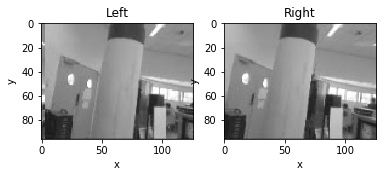

In [5]:
def read_stereo_image(im="test_image.bmp"):
    cv_im = cv2.imread(im);
    imgL = cv_im[0:96, 126:252, :];
    imgR = cv_im[0:96, 0:126, :];
    return [imgL, imgR]

# read the image:
[imgL, imgR] = read_stereo_image();# show the images
plt.figure();
plt.subplot(121)
plt.imshow(imgL);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Left');

plt.subplot(122)
plt.imshow(imgR);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Right');

### Pixel difference based matching

For each pixel in the left image, at location $(x, y)$, search the corresponding pixel in the right image by looking at the image intensity of a single pixel. So, the pixel intensity in the left image is $I_l(x,y)$. The algorithm then starts at $(x,y)$ in the right image and then moves more and more to the left. In other words, the algorithm looks at the intensity in the right image $I_r(x-d, y)$, for the disparity $d$ in a given fixed range $[0, D]$. The absolute difference between the pixel intensities, $|I_l(x,y) - I_r(x-d, y)|$ is stored for all disparities $d$, and the disparity resulting in the minimal absolute difference is selected as the correct disparity. 

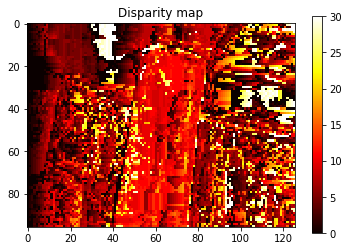

In [18]:
def simple_stereo(imgL, imgR, max_disparity=30):
    
    W = imgL.shape[1];
    H = imgL.shape[0];
    
    # create the disparities image:
    Disparities = np.zeros([H, W]);
    
    # loop over the image
    for x in range(W):
        
        # in the left border of the left image, not all disparities can be investigated:
        max_disp = np.min([x, max_disparity]);
        disps = np.arange(0, max_disp+1);
        
        for y in range(H):
            # we can determine the differences in one go:
            differences = np.abs(imgL[y,x,0] - imgR[y, x-max_disp:x+1,0]);
            differences = differences[::-1];
            # the minimal difference determines the disparity
            disp_ind = np.argmin(differences);
            disparity = disps[disp_ind];
            Disparities[y, x] = disparity;
    
    return Disparities;


D = simple_stereo(imgL, imgR, max_disparity = 30);

plt.figure();
plt.imshow(D, cmap='hot');
plt.colorbar();
plt.title('Disparity map');
plt.draw()

The following code will allow us to select an image coordinate $(x,y)$ in the left image, and show the according differences array.

Image size, width = 126, height = 96


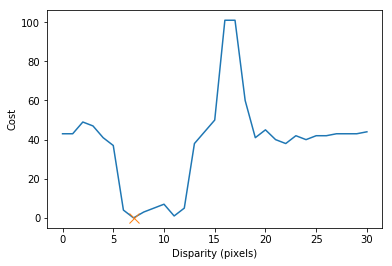

In [19]:
def get_differences_curve(imgL, imgR, x, y, max_disparity=30):
    
    # determine the disparities that will be investigated:
    max_disp = np.min([x, max_disparity]); # make sure that we will not investigate negative indices
    disps = np.arange(0, max_disp+1);
    
    # we can determine the differences in one go:
    differences = np.abs(imgL[y,x,0] - imgR[y, x-max_disp:x+1,0]);
    differences = differences[::-1];
    # the minimal difference determines the disparity
    disp_ind = np.argmin(differences);
    disparity = disps[disp_ind];
    
    return [differences, disps, disp_ind];

print('Image size, width = {}, height = {}'.format(imgL.shape[1], imgL.shape[0]))
[differences, disps, disp_ind] = get_differences_curve(imgL, imgR, x=40, y=60); 
plt.figure();
plt.plot(disps, differences);
plt.plot(disps[disp_ind], differences[disp_ind], 'x', markersize=10);
plt.xlabel('Disparity (pixels)')
plt.ylabel('Cost')
plt.draw();

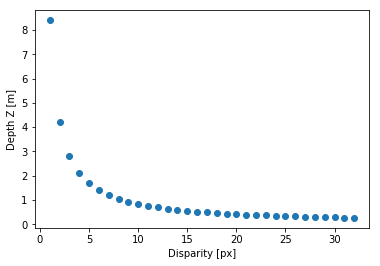

In [25]:
def plot_relation_disparity_depth(f = 300, T_X = 0.10, max_disp = 64):
    """ Focal length f is in pixels, max_disp (maximum disparity) is in pixels and b is in meters,.
    """
    
    step_disp = 1;
    disparities = np.arange(1, max_disp+1, step_disp);
    depths = np.zeros(len(disparities));
    i = 0;
    for disp in disparities:
        depths[i] = f * (T_X / disp);
        i += 1;
    
    plt.figure();
    plt.plot(disparities, depths, 'o');
    plt.xlabel('Disparity [px]')
    plt.ylabel('Depth Z [m]')

plot_relation_disparity_depth(f = 140, T_X = 0.06, max_disp = 32)

### Window difference based matching
A major reason for the poor results in the naive difference-based stereo algorithm is that a single pixel is a very poor basis for matching between images. A given pixel value may occur in many different regions of the image, also on a single scan line. The next simplest stereo vision algorithm acknowledges this fact, and hence focuses on the differences between pixels in a window centered on $(x,y)$ and $(x-d, y)$.  The figiure of merit "SAD" computed using an entire window C is defined as :

SAD $= \sum_{i=-C}^C \sum_{j=-C}^C \left| I_l(x+i, y+j) - I_r(x+i-d, y+j) \right| $,

where SAD stands for the Sum of Absolute Differences, and serves as the new 'difference' value. The window size is $2C+1$. The final result is shown for a maximum disparity of 30 and half window size $C=3$.

In [10]:
def windowed_stereo(imgL, imgR, max_disparity=30, window_half_size=3):
    
    W = imgL.shape[1];
    H = imgL.shape[0];
    
    # create the disparities image:
    Disparities = np.zeros([H, W]);
    
    # loop over the image
    for x in np.arange(window_half_size, W-window_half_size):
        
        # in the left border of the left image, not all disparities can be investigated:
        max_disp = np.min([x-window_half_size, max_disparity]);
        if(max_disp >= 0):
            disps = np.arange(0, max_disp+1);
            differences = np.zeros([len(disps), 1]);
            
            for y in np.arange(window_half_size, H-window_half_size):
                
                window_left = imgL[y-window_half_size:y+window_half_size, x-window_half_size:x+window_half_size, 0];
                
                for d in disps:
                    window_right = imgR[y-window_half_size:y+window_half_size, x-d-window_half_size:x-d+window_half_size, 0];
                    differences[d] = np.sum(np.abs(window_left.astype(float) - window_right.astype(float)));
                
                # the minimal difference determines the disparity
                disp_ind = np.argmin(differences);
                disparity = disps[disp_ind];
                Disparities[y, x] = disparity;
    
    return Disparities;

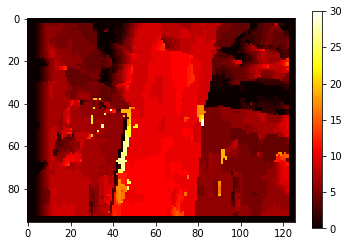

In [23]:
D = windowed_stereo(imgL, imgR, max_disparity=30, window_half_size=3);
plt.figure();
plt.imshow(D, cmap='hot');
plt.colorbar();
plt.draw()

 Both the above algorithms algorithms only look at what the best disparity is. That is, for each coordinate $(x,y)$ they select the disparity with lowest error, without considering certain regularities in the real world. For instance, in the real world, disparities tend to change smoothly when pixels belong to the same object and then may change abruptly when there is an edge of the object. _Global_ methods take such regularities into account, i.e., they make some assumptions on how disparities change over the image and optimize the disparities over the whole image. 

## Semi-Global Block Matching (SGBM) 

Stereo vision algorithms can be better in terms of accuracy, or computational effort, or both. There are is an increasing number of algorithms that satisfies both criteria quite well. A well-known algorithm that is quite efficient and accurate is "Semi-global block matching" - _SGBM_, (see H. Hirschmuller, "Stereo processing by semiglobal matching and mutual information", IEEE Transactions on pattern analysis and machine intelligence, 30, pp. 328-341)


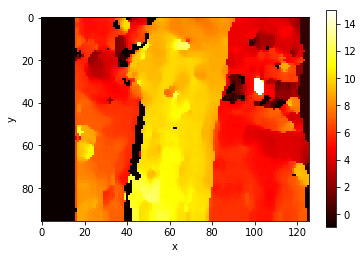

In [24]:
def calculate_disparities(imgL, imgR, window_size=7, min_disp=0, num_disp=16):
    # semi-global matching:
    stereo = cv2.StereoSGBM_create(numDisparities = num_disp, blockSize = window_size);
    disp = stereo.compute(imgL, imgR).astype(np.float32) / 16.0;
    return disp;

D = calculate_disparities(imgL, imgR, window_size=7, min_disp=0, num_disp=16)
plt.figure();
plt.imshow(D, cmap='hot');
plt.colorbar();
plt.xlabel('x');
plt.ylabel('y');
plt.draw()